# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 2</span>


### Exercise 02.1
- Compute the following 1D integral via Monte Carlo 
$$I = \int_0^1 \frac{\pi}{2}\cos(\pi x/2) dx = 1$$

1. sampling a uniform distribution in $[0,1]$
2. using importance sampling (i.e. sampling a non-uniform probability in $[0,1]$)

<span style="color:red">Show a picture of both your estimations of $I$</span> and their uncertainties with a large number of *throws* $M$ (e.g. $M\ge 10^4$) as a function of the number of blocks, $N$</font>.

### Solution:

The function:

$$f(x) = \frac{\pi}{2} \cos{\left( \frac{\pi}{2} x \right)}$$

is a periodic function of period $4$. Being a cosine, the first quarter of its cycle ($x \in (0,1)$) has the function being motonically decreasing from $\pi/2$ to 0. A smart choice for a sampling distribution would be the Taylor expansion of $f$ around $\frac 1 2$, truncated at the second order.

$$\frac{\pi}{2} \cos{\left( \frac \pi 2 x \right)} \approx \frac{\pi \sqrt{2}}{4} \left[1 - \frac \pi 2 \left(x-\frac 1 2 \right) - \frac{\pi^2}{8} \left( x - \frac 1 2 \right)^2 \right] = \frac{\pi \sqrt{2}}{4} \left[1 - \frac \pi 2 x + \frac \pi 4 - \frac{\pi^2}{8} x^2 + \frac{\pi^2}{8} x - \frac{\pi^2}{32} \right] $$

$$ = \frac{\pi \sqrt{2}}{4} \left[ - \frac{\pi^2}{8} x^2 + \left( \frac{\pi^2}{8} - \frac \pi 2 \right) x + \left( 1 + \frac \pi 4 - \frac{\pi^2}{32} \right) \right]$$

this a polynomial of order 2, which draws a parabola with negative curvature peaked in $x = \frac 1 2 - \frac 2 {\pi} \approx -0.14$. Therefore this is a decreasing function inside the interval $(0,1)$:

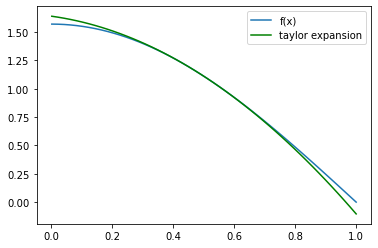

Maximum value: 1.6405045641821652 
minimum value: -0.10421148572755451


In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd 

def f(x):
    C = math.pi/2
    return C*np.cos(C*x)
def taylor(x):
    D = 1/math.sqrt(2)
    C = math.pi/2
    return C*D*(1 - C*(x-0.5) - 0.5*C*C*((x-0.5)**2))
x = np.linspace(0.001, 1)
plt.plot(x, f(x), label='f(x)')
plt.plot(x, taylor(x), color='green', label='taylor expansion')
plt.legend()
plt.show()

print("Maximum value:", taylor(0), "\nminimum value:", taylor(1))

This function can't be used as a distribution, as it is negative for some points inside the interval. However, the minimum value is just below zero ($\frac{\pi \sqrt 2}{4}(1 - {\pi}/{4} - {\pi^2}/{32}) \approx -0.1$), so this can be easily fixed by adding the difference to the function. 

$$ \frac{\pi \sqrt{2}}{4} \left[ - \frac{\pi^2}{8} x^2 + \left( \frac{\pi^2}{8} - \frac \pi 2 \right) x + \left( 1 + \frac \pi 4 - \frac{\pi^2}{32} \right) - \left( 1 - \frac{\pi}{4} - \frac{\pi^2}{32} \right) \right] = \frac{\pi \sqrt{2}}{4} \left[ - \frac{\pi^2}{8} x^2 + \left( \frac{\pi^2}{8} - \frac \pi 2 \right) x + \frac \pi 2 \right]$$

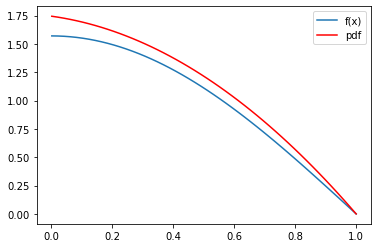

Maximum value: 1.7447160499097196 
minimum value: 0.0


In [2]:
def approx(x):
    #return (taylor(x) - taylor(1))/(taylor(0) - taylor(1))
    return (taylor(x) - taylor(1))
x = np.linspace(0.001, 1)
plt.plot(x, f(x), label='f(x)')
#plt.plot(x, taylor(x), color='green', label='taylor expansion')
plt.plot(x, approx(x), color='red', label='pdf')
plt.legend()
plt.show()

print("Maximum value:", approx(0), "\nminimum value:", approx(1))

I now have to normalize this function:

$$ \int_0^1 \frac{\pi \sqrt{2}}{4} \left[ - \frac{\pi^2}{8} x^2 + \left( \frac{\pi^2}{8} - \frac \pi 2 \right) x + \frac \pi 2 \right] \, \text d x $$

$$ = \frac{\pi \sqrt{2}}{4} \left[ - \frac{\pi^2}{24} + \left( \frac{\pi^2}{16} - \frac \pi 4 \right) + \frac \pi 2 \right] = \frac{\pi \sqrt{2}}{4} \left( \frac{\pi^2}{48} + \frac \pi 4 \right) $$

My sampling distribution will therefore be:

$$p(x) = \frac{- \frac{\pi^2}{8} x^2 + \left( \frac{\pi^2}{8} - \frac \pi 2 \right) x + \frac \pi 2}{\frac{\pi^2}{48} + \frac \pi 4} = \frac{- \frac{\pi}{4} x^2 + \left( \frac{\pi}{4} - 1 \right) x + 1}{\frac{\pi}{24} + \frac 1 2} = \frac{\left(\frac{\pi}{4} x + 1 \right) (1-x)}{\frac{\pi}{24} + \frac 1 2}$$

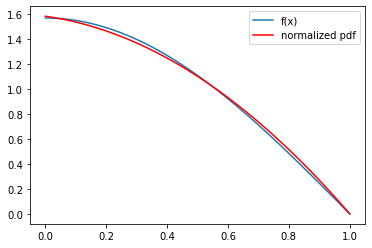

Maximum value: 1.585038017404995 
minimum value: 0.0


In [3]:
def normalized(x):
    return (math.pi*x/4 + 1)*(1 - x)/(math.pi/24 + 0.5)
x = np.linspace(0.001, 1)
plt.plot(x, f(x), label='f(x)')
plt.plot(x, normalized(x), color='red', label='normalized pdf')
plt.legend()
plt.show()

print("Maximum value:", normalized(0), "\nminimum value:", normalized(1))

and I will sample:

$$g(x) = \frac{f(x)}{p(x)} = \frac{\frac{\pi^2}{48} + \frac{\pi}{4}}{\left(\frac{\pi}{4} x + 1 \right) (1-x)} \cos{\left( \frac{\pi}{2} x \right)} $$

In order to perform inversion sampling I need to generate pseudo-random numbers from $p(x)$. To do so I used the accept-reject technique: I generate a set of two coordinates uniformly in a plane given by the interval width times the maximum value of the function, then I only keep the points "under" the curve (i.e. the points for which $y < p(x)$)

I then computed the integral $I$ using Monte Carlo, first using the pseudo-random number generator, which samples from a uniform distribution, then using importance sampling. I used the same number of blocks ($1000$) and the same blocksize ($1000$) as in the previous lesson:

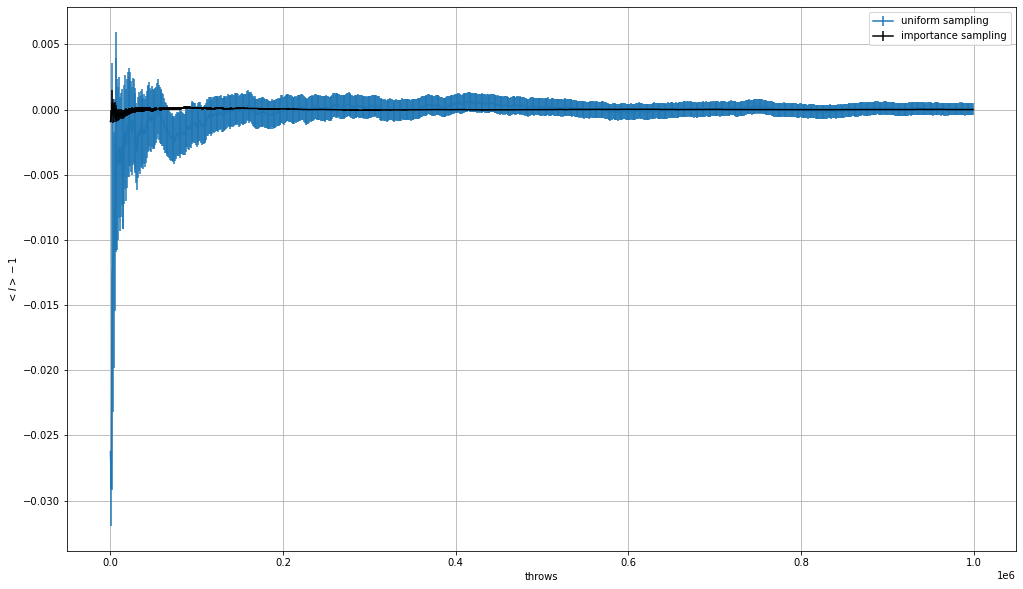

In [4]:
data = pd.read_csv('output.dat', delimiter='\t', header=None, names=['Uniform', 'Usigma', 'Importance', 'Isigma'])

#print(df)

N=len(data['Uniform'])
L=1000
x = np.arange(N)      # [0,1,2,...,N-1]
    
x*=L # Number of throws = block * (Number of throws in each block)
plt.figure(figsize=(17,10))
plt.errorbar(x,data['Uniform']-1,yerr=data['Usigma'],label='uniform sampling',alpha=1.0)
plt.errorbar(x,data['Importance']-1,yerr=data['Isigma'],color='k',label='importance sampling')
plt.xlabel('throws')
plt.ylabel('$<I> - 1$')
plt.grid(True)
plt.legend()
plt.show()

Both techniques correctly compute the integral, but the importance sampling approach has a much lower statistical uncertainty.

### Exercise 02.2
- <span style="color:red">3D Random Walks (RW) on a cubic lattice and in the continuum:</span> Repeat many times (e.g. say $10^4$) the simulation of a random walk in 3D always starting at the origin

1. on a cubic lattice with lattice constant $a=1$; at each discrete time the walker makes a forward or backward step of length equal to $a$ in one of the 3 principal directions of the lattice: $x$, $y$ or $z$
2. in the continuum; at each discrete time the walker makes a step of length equal to $a(=1)$ along a **random direction** obtained by sampling **uniformly** the solid angle: $\theta \in [0,\pi]$ and $\phi \in [0,2\pi]$

<span style="color:red">Show a picture of $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ for both RWs</span>, with their statistical uncertainties, as function of the step $i\in [0,10^2]$.

Suggestion: divide your $M$ throws into a reasonable number of blocks, compute $\sqrt{\langle |\vec{r}_N|^2 \rangle_{RW}}$ as function of the step $i\in [0,10^2]$ in each block and use these values (for fixed $i$) to obtain the average value and its statistical uncertainty.

Note that you could try to fit both results with a function like $f(N)=k\sqrt{N}$. Do your results indicate a diffusive behavior?

### Solution:

I computed 1 million discrete random walks and 1 million continuous random walks, all of them $100$ steps long. I used the block average method (with the usual 1000 blocks of size 1000) to compute the average distance from the origin (displacement) after each step.

To do so, I computed the average of the square modulus of the position vector and then took the squared root of the average. The statistical uncertainty obtained by block averaging is referred to the square modulus, and to compute the correct one I used error propagation:

$$\sigma = \sqrt{\left(\frac{\partial \sqrt{x}}{\partial x}\right)^2 \sigma_x^2} = \frac{\sigma_x}{2\sqrt{x}}$$

Here's the results after $2$, $10$ and $100$ steps:

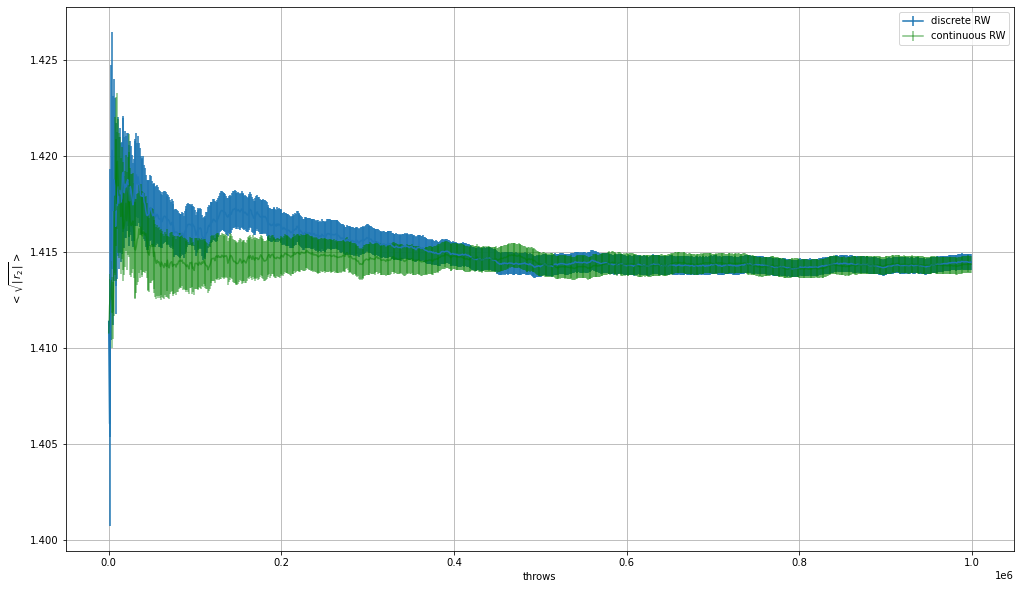

In [5]:
discrete_rw = pd.read_csv('discrete_output.dat', delimiter='\t', header=None, names=['i', 'module', 'sigma'])
continuous_rw = pd.read_csv('continuous_output.dat', delimiter='\t', header=None, names=['i', 'module', 'sigma'])

#print(discrete_rw)

d_indexes = discrete_rw.i.unique()
c_indexes = continuous_rw.i.unique()

#create a data frame dictionary to store data frames
DRW = {elem : pd.DataFrame() for elem in d_indexes}
CRW = {elem : pd.DataFrame() for elem in c_indexes}

for key in DRW.keys():
    DRW[key] = discrete_rw[:][discrete_rw.i == key]
    
for key in CRW.keys():
    CRW[key] = continuous_rw[:][continuous_rw.i == key]
    
#print(CRW[99])

N=len(DRW[1]['module'])
L=1000
x = np.arange(N)      # [0,1,2,...,N-1]
    
x*=L # Number of throws = block * (Number of throws in each block)
plt.figure(figsize=(17,10))
plt.errorbar(x,DRW[1]['module'],yerr=DRW[1]['sigma'],label='discrete RW')
plt.errorbar(x,CRW[1]['module'],yerr=CRW[1]['sigma'],label='continuous RW',color='green',alpha=0.5)
plt.xlabel('throws')
plt.ylabel('$<\sqrt{|\,r_2\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

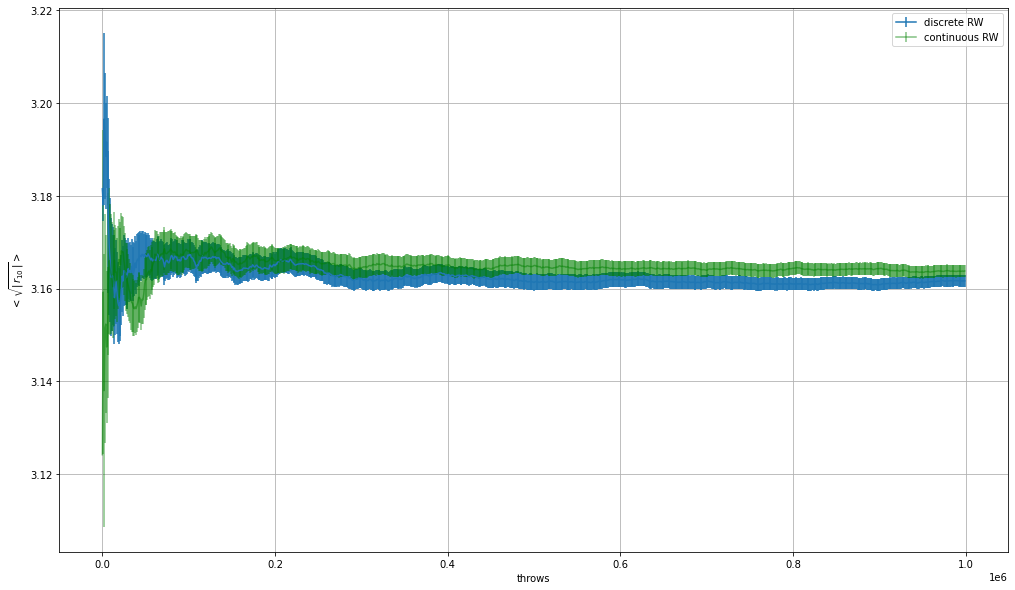

In [6]:
plt.figure(figsize=(17,10))
plt.errorbar(x,DRW[9]['module'],yerr=DRW[9]['sigma'],label='discrete RW')
plt.errorbar(x,CRW[9]['module'],yerr=CRW[9]['sigma'],label='continuous RW',color='green',alpha=0.5)
plt.xlabel('throws')
plt.ylabel('$<\sqrt{|\,r_{10}\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

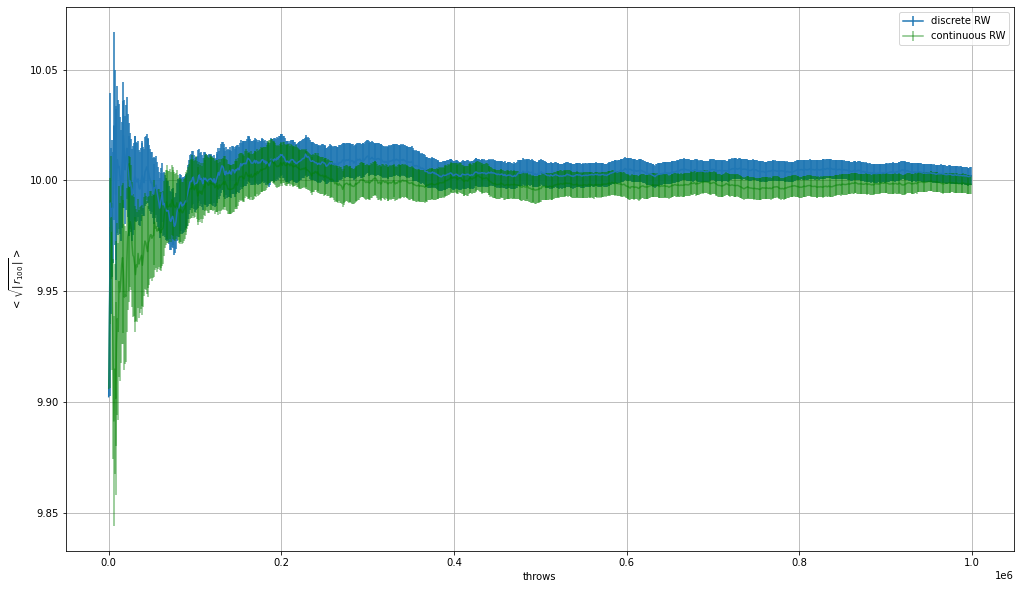

In [7]:
plt.figure(figsize=(17,10))
plt.errorbar(x,DRW[99]['module'],yerr=DRW[99]['sigma'],label='discrete RW')
plt.errorbar(x,CRW[99]['module'],yerr=CRW[99]['sigma'],label='continuous RW',color='green',alpha=0.5)
plt.xlabel('throws')
plt.ylabel('$<\sqrt{|\,r_{100}\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

From these three pictures is clear that the discrete and continuous random walks tend to have very similar behaviours, and the average distance from the origin is pretty much the same in both cases (regardless of the number of steps). I then focused on the behaviour of the average displacement as a function of the number of steps.

In [8]:
def f(n, k):
    return k*np.sqrt(n)

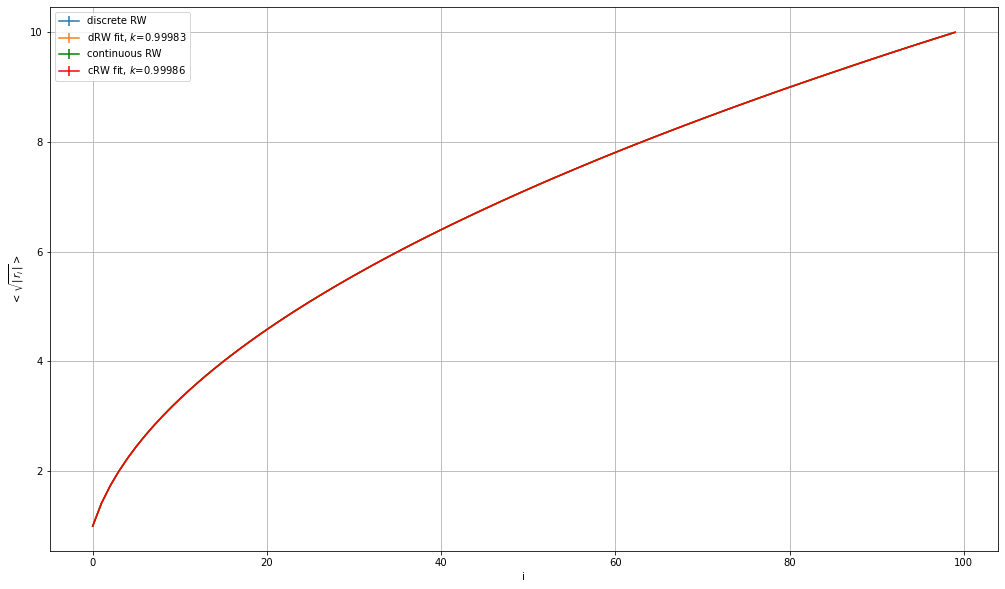

χ² of the fit (discrete case):			0.00004440
reduced χ² of the fit (discrete case):		0.00000045
χ² of the fit (continuous case):		0.00003750
reduced χ² of the fit (continuous case):	0.00000038


In [9]:
from scipy.optimize import curve_fit

temp_list = []
for key in DRW.keys():
    slave = DRW[key].iloc[-1:]
    temp_list.append(slave)
ADRW = pd.concat(temp_list) #Average Discrete Random Walk

#print(ADRW)

temp_list = []
for key in CRW.keys():
    slave = CRW[key].iloc[-1:]
    temp_list.append(slave)
ACRW = pd.concat(temp_list) #Average Continuous Random Walk

#print(ACRW)

x = np.arange(100) #number of steps
kfit, kcov = curve_fit(f, (ADRW['i']+1).tolist(), ADRW['module'].tolist())
kfit = kfit[0]
cfit, ccov = curve_fit(f, (ACRW['i']+1).tolist(), ACRW['module'].tolist())
cfit = cfit[0]

plt.figure(figsize=(17,10))
plt.errorbar(x,ADRW['module'],yerr=ADRW['sigma'],label='discrete RW')
plt.errorbar(x,f(x+1, kfit),yerr=0,label=r'dRW fit, $k$=' + f'{kfit:.5f}')
plt.errorbar(x,ACRW['module'],yerr=ACRW['sigma'],label='continuous RW',color='green')
plt.errorbar(x,f(x+1, cfit),yerr=0,label=r'cRW fit, $k$=' + f'{cfit:.5f}',color='red',alpha=1)
plt.xlabel('i')
plt.ylabel('$<\sqrt{|\,r_{i}\,|}>$')
plt.grid(True)
plt.legend()
plt.show()

d_chisq = np.sum((ADRW['module'] - f(x+1, kfit))**2 / f(x+1, kfit))
red_d_chisq = d_chisq / (len(x) - 2)

print(f'\N{GREEK SMALL LETTER CHI}\N{SUPERSCRIPT TWO} of the fit (discrete case):\t\t\t{d_chisq:.8f}')
print(f'reduced \N{GREEK SMALL LETTER CHI}\N{SUPERSCRIPT TWO} of the fit (discrete case):\t\t{red_d_chisq:.8f}')

c_chisq = np.sum((ACRW['module'] - f(x+1, cfit))**2 / f(x+1, cfit))
red_c_chisq = c_chisq / (len(x) - 2)

print(f'\N{GREEK SMALL LETTER CHI}\N{SUPERSCRIPT TWO} of the fit (continuous case):\t\t{c_chisq:.8f}')
print(f'reduced \N{GREEK SMALL LETTER CHI}\N{SUPERSCRIPT TWO} of the fit (continuous case):\t{red_c_chisq:.8f}')

Here's a picture of the average displacement as a function of the number of steps $i$, for both the discrete and continuous case, together with the statistical uncertainties. I also fitted the function $f(n) = k\sqrt{n}$ to both curves, and in both cases I got a value of $k$ very close to 1. 

The 4 curves are poorly distinguishable from each other because they are all very close to each other, and the statistical uncertainties are relatively small.

In both cases, the process shows a diffusive behaviour, as the mean squared displacement grows linearly with the number of steps.